In [5]:
#! /usr/bin/env python3
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft

import matplotlib as mpl
from matplotlib import cm

from collections import OrderedDict
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


cmaps = OrderedDict()

In [6]:
FILE = 'GEN3CH_4_009.dig'

In [7]:
# coding:utf-8

"""
::

   Author:  LANL Clinic 2019 --<lanl19@cs.hmc.edu>
   Purpose: Compute a spectrogram from a DigFile
   Created: 9/20/19
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from digfile import DigFile


class Spectrogram:
    """

    A Spectrogram takes a DigFile and a time range, as
    well as plenty of options, and generates a spectrogram
    using scipy.signal.spectrogram.

    Required arguments to the constructor:
        digfile: either an instance of DigFile or the filename of a .dig file

    **Optional arguments and their default values**

    t_start: (digfile.t0) time of the first point to use in the spectrogram
    ending:  (None) either the time of the last point or a positive integer
             representing the number of points to use; if None, the final
             point in the digfile is used.
    wavelength: (1550.0e-9) the wavelength in meters
    points_per_spectrum: (8192) the number of values used to generate
        each spectrum. Should be a power of 2.
    overlap: (1/4) the fraction of points_per_spectrum to overlap in
        successive spectra. An overlap of 0 means that each sample is used
        in only one spectrum. The default value means that successive
        spectra share 1/4 of their source samples.
    window_function: (None) the window function used by signal.spectrogram.
        The default value implies a ('tukey', 0.25) window.
    form: ('db') whether to use power values ('power'), decibels ('db'),
        or log(power) ('log') in reporting spectral intensities.
    convert_to_voltage: (True) scale the integer values stored in the
        .dig file to voltage before computing the spectrogram. If False,
        the raw integral values are used.
    detrend: ("linear") the background subtraction method.

    **Computed fields**

    t:         array of times at which the spectra are computed
    f:         array of frequencies present in each spectrum
    v:         array of velocities corresponding to each spectrum
    intensity: two-dimensional array of (scaled) intensities, which
               is the spectrogram. The first index corresponds to
               frequency/velocity, the second to time.
    """

    _fields = ("points_per_spectrum",
               "overlap",
               "window_function",
               "form",
               "use_voltage",
               "detrend")

    def __init__(self,
                 digfile,
                 t_start=None,
                 ending=None,
                 wavelength=1550.0e-9,
                 points_per_spectrum=8192,
                 overlap=0.25,
                 window_function=None,  # 'hanning',
                 form='db',
                 convert_to_voltage=True,
                 detrend="linear",
                 **kwargs
                 ):
        """
        TODO: We are currently not handling kwargs
        """
        if isinstance(digfile, str):
            digfile = DigFile(digfile)
        if isinstance(digfile, DigFile):
            self.data = digfile
        else:
            raise TypeError("Unknown file type")

        self.t_start = t_start if t_start != None else self.data.t0
        p_start, p_end = self.data._points(self.t_start, ending)
        self.t_end = self.t_start + self.data.dt * (p_end - p_start + 1)

        self.wavelength = wavelength
        self.points_per_spectrum = points_per_spectrum
        self.overlap = overlap
        self.window_function = window_function
        self.form = form
        self.use_voltage = convert_to_voltage
        self.detrend = detrend

        # the following will be set by _calculate
        self.time = None
        self.frequency = None
        self.velocity = None
        self.intensity = None

        # deal with kwargs

        try:
            if False:
                self._load()
            else:
                raise Exception()
        except:
            self._compute(ending)
            # self._save()

    def _compute(self, ending):
        """
        Compute a spectrogram. This needs work! There need to be
        lots more options that we either want to supply with
        default values or decode kwargs. But it should be a start.
        """
        if self.use_voltage:
            vals = self.data.values(self.t_start, ending)
        else:
            vals = self.data.raw_values(self.t_start, ending)

        # if normalize:
        #    vals = self.normalize(
        #        vals, chunksize=fftSize, remove_dc=remove_dc)
        freqs, times, spec = signal.spectrogram(
            vals,
            1.0 / self.data.dt,  # the sample frequency
            window=self.window_function if self.window_function else (
                'tukey', 0.25),
            nperseg=self.points_per_spectrum,
            noverlap=int(self.overlap * self.points_per_spectrum),
            detrend=self.detrend,  # could be constant,
            scaling="spectrum"
        )
        times += self.t_start
        # Attempt to deduce baselines
        # baselines = np.sum(spec, axis=1)

        # Convert to a logarithmic representation and use floor to attempt
        # to suppress some noise.
        spec *= 2.0 / (self.points_per_spectrum * self.data.dt)
        epsilon = 1e-10  # use this to suppress the divide by zero warnings
        if self.form == 'db':
            spec = 20 * np.log10(spec + epsilon)
        elif self.form == 'log':
            spec = np.log10(spec + epsilon)
        self.intensity = spec  # a two-dimensional array
        # the first index is frequency, the second time

        self.frequency = freqs
        self.time = times

        # scale the frequency axis to velocity
        self.velocity = freqs * 0.5 * self.wavelength  # velocities

    def set(self, **kwargs):
        """
        Update the spectrogram to use the new parameters
        specified in the keyword arguments. If any changes cause
        the underlying values to change, recompute the spectrogram.
        """
        changed = False
        for field in self._fields:
            if field in kwargs and kwargs[field] != getattr(self, field):
                changed = True
                setattr(self, field, kwargs[field])
        if changed:
            self._compute(None)

    def __str__(self):
        return ", ".join(
            [str(x) for x in
             [self.data.filename,
              f"{self.points_per_spectrum} / {self.shift}",
              self.form,
              self.intensity.shape
              ]
             ])

    def _point_to_time(self, p):
        "Map a point index to a time"
        return self.time[p]

    def _time_to_index(self, t):
        "Map a time to a point number"
        p = (t - self.t_start) / (self.time[1] - self.time[0])
        p = int(0.5 + p)  # round to an integer
        if p < 0:
            return 0
        return min(p, len(self.time) - 1)

    def _velocity_to_index(self, v):
        "Map a velocity value to a point number"
        p = (v - self.velocity[0]) / (self.velocity[1] - self.velocity[0])
        p = int(0.5 + p)  # round
        if p < 0:
            return 0
        return min(p, -1 + len(self.velocity))

    def slice(self, time_range, velocity_range):
        """
        Input:
            time_range: Array/Tuple/List of times (t0, t1)
                t0 should be greater than t1 but we will handle the other case
            velocity_range: Array/Tuple/List of velocities (v0, v1)
                v0 should be greater than v1 but we will handle the other case
        Output:
            3 arrays time, velocity, intensity
            time: the time values used in the measurement from t0 to t1 inclusive.
            velocity: the velocity values measured from v0 to v1 inclusive.
            intensity: the corresponding intensity values that we measured.
        """
        if time_range == None:
            time0, time1 = 0, len(self.time) - 1
        else:
            time0, time1 = [self._time_to_index(t) for t in time_range]
        if velocity_range == None:
            vel0, vel1 = 0, len(self.velocity) - 1
        else:
            vel0, vel1 = [self._velocity_to_index(v) for v in velocity_range]
        if time0 > time1:
            # Then we will just swap them.
            tmp = time0
            time0 = time1
            time1 = time0
        if vel0 > vel1:
            # Then we will just swap them so that we can index normally.
            tmp = vel0
            vel0 = vel1
            vel1 = tmp
        tvals = self.time[time0:time1 + 1]
        vvals = self.velocity[vel0:vel1 + 1]
        ivals = self.intensity[vel0:vel1+1, time0:time1+1]
        return tvals, vvals, ivals


    # Routines to archive the computed spectrogram and reload from disk

    def _location(self, location, create=False):
        """

        """
        if location == "":
            location = os.path.splitext(self.data.path)[0] + \
                '.spectrogram'
        if os.path.exists(location) and not os.path.isdir(location):
            raise FileExistsError
        if not os.path.exists(location) and create:
            os.mkdir(location)
        return location

    def _save(self, location=""):
        """
        Save a representation of this spectrogram.
        The format is a folder holding the three numpy arrays
        and a text file with the parameters.
        If the location is a blank string, the folder has
        the name of the digfile, with .dig replaced by .spectrogram.
        """
        location = self._location(location, True)
        with open(os.path.join(location, "properties"), 'w') as f:
            for field in self._fields:
                f.write(f"{field}\t{getattr(self,field)}\n")
        np.savez_compressed(
            os.path.join(location, "vals"),
            velocity=self.velocity,
            frequency=self.frequency,
            time=self.time,
            intensity=self.intensity)

    def _load(self, location=""):
        location = self._location(location)
        if not os.path.isdir(location):
            raise FileNotFoundError
        try:
            with open(os.path.join(
                    location, "properties"), 'r') as f:
                for line in f.readlines():
                    field, value = line.split('\t')
                    assert value == getattr(field)
            loaded = np.load(os.path.join(location, "vals"))
            for k, v in loaded.items():
                setattr(self, k, v)
            return True
        except Exception as eeps:
            print(eeps)
        return False

    @property
    def max(self):
        """The maximum intensity value"""
        return self.intensity.max()

    @property
    def v_max(self):
        return self.wavelength * 0.25 / self.data.dt

    def power(self, values):
        """
        Given an np.array of intensity values from the spectrogram,
        return the corresponding power values (undoing any logarithms,
        if necessary).
        """
        if self.form == 'db':
            return np.power(10.0, 0.05 * values)
        if self.form == 'log':
            return np.power(10.0, values)
        return values

    def plot(self, axes=None, **kwargs):
        # max_vel=6000, vmin=-200, vmax=100):
        if axes == None:
            axes = plt.gca()
        if 'max_vel' in kwargs:
            axes.set_ylim(top=kwargs['max_vel'])
            del kwargs['max_vel']
        if 'max_time' in kwargs:
            axes.set_xlim(right=kwargs['max_time'])
            del kwargs['max_time']

        pcm = axes.pcolormesh(
            self.time * 1e6,
            self.velocity,
            self.intensity,
            **kwargs)

        plt.gcf().colorbar(pcm, ax=axes)
        axes.set_ylabel('Velocity (m/s)')
        axes.set_xlabel('Time ($\mu$s)')
        title = self.data.filename.split('/')[-1]
        axes.set_title(title.replace("_", "\\_"))
        return pcm

        # bestVelocity = self.extract_velocities(sgram)

        # fig = plt.figure()
        # plt.plot(sgram['t'], bestVelocity, color="red")


if False:
    def scan_data(self):
        """
        Load the entire file and determine the range of raw integer values
        """
        raw = self.raw_values(self.t0, self.num_samples)
        self.raw = dict(min=np.min(raw), max=np.max(raw), mean=np.mean(raw))
        self.raw['range'] = self.raw['max'] - self.raw['min']
#         instrument_spec_codes = {
#             'BYT_N': 'binary_data_field_width',
#             'BIT_N': 'bits',
#             'ENC': 'encoding',
#             'BN_F': 'number_format',
#             'BYT_O': 'byte_order',
#             'WFI': 'source_trace',
#             'NR_P': 'number_pixel_bins',
#             'PT_F': 'point_format',
#             'XUN': 'x_unit',
#             'XIN': 'x_interval',
#             'XZE': 'post_trigger_seconds',
#             'PT_O': 'pulse_train_output',
#             'YUN': 'y_unit',
#             'YMU': 'y_scale_factor',
#             'YOF': 'y_offset',
#             'YZE': 'y_component',
#             'NR_FR': 'NR_FR'

    def __str__(self):
        return "\n".join([
            self.filename,
            f"{self.bits} bits" +
            f" {self.notes['byte_order']} first" if 'byte_order' in self.notes else "",
            f"{self.t0*1e6} µs to {(self.t0 + self.dt*self.num_samples)*1e6} µs in steps of {self.dt*1e12} ps"
        ])

    def normalize(self, array, chunksize=4096, remove_dc=True):
        """
        Given an array of periodically sampled points, normalize to a
        peak amplitude of 1, possibly after removing dc in segments of
        chunksize.
        """
        if remove_dc:
            num_chunks, num_leftovers = divmod(len(array), chunksize)
            if num_leftovers:
                leftovers = array[-num_leftovers:]
                chunks = array[:num_chunks *
                               chunksize].reshape((num_chunks, chunksize))
                avg = np.mean(leftovers)
                leftovers -= avg
            else:
                chunks = array.reshape((num_chunks, chunksize))
            # compute the average of each chunk
            averages = np.mean(chunks, axis=1)
            # shift each chunk to have zero mean
            for n in range(num_chunks):
                chunks[n, :] -= averages[n]
            flattened = chunks.reshape(num_chunks * chunksize)
            if num_leftovers:
                flattened = np.concatenate((flattened, leftovers))
        else:
            flattened = array

        # Now normalize, making the largest magnitude 1
        peak = np.max(np.abs(array))
        return flattened / peak

    def spectrum(self, t, nSamples, remove_dc=True):
        """
        Compute a spectrum from nSamples centered at time t
        """
        from spectrum import Spectrum
        tStart = t - nSamples // 2 * self.dt
        if tStart < self.t0:
            tStart = self.t0
        raw = self.values(tStart, nSamples)
        return Spectrum(raw, self.dt, remove_dc)



In [8]:
spec = Spectrogram("GEN3CH_4_009.dig")

<function matplotlib.pyplot.show(*args, **kw)>

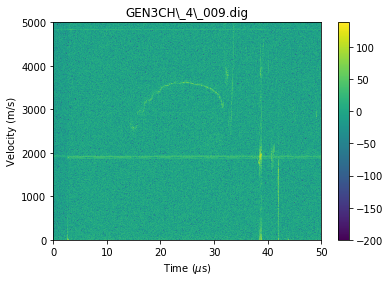

In [9]:
spec.plot(max_vel=5000, max_time = 50)
plt.show

In [85]:
times, velocities, intensities = spec.slice((spec.time[10],spec.time[20]),(1000,2000))


In [116]:
times[0]

-0.0001985664

In [12]:
len(intensities[:,2])

340

In [13]:
maxIndex = np.argmax(intensities[:,2])
print(maxIndex)
for i in range(0,2):
    print(velocities[np.argmax(intensities[:,i])])

77
3107.757568359375
2488.09814453125


In [117]:
def greedy(spectogram,tstart,tend,vstart,vend):
    times,velocites,intensities = spec.slice((spec.time[tstart],spec.time[tend]),(vstart,vend))
    greedyIndex = np.zeros(tend-tstart,dtype=int)
    
    #greedyVels is storing the index of the velocities
    greedyIndex[0] = int(np.argmax(intensities[:,0]))
#     print(greedyVels)
    i = 1
    while i != tend-tstart:
#         print(i)
#         print(int(greedyIndex[i-1]))
        greedyIndex[i] = greedyCompare(intensities[:,i],intensities[:,i+1],greedyIndex[i-1])
        i += 1
    print( greedyIndex)
    Vcoords = np.zeros(tend-tstart)
    Tcoords = np.zeros(tend-tstart)
#     print(coords)
    i = 0
    while i != tend-tstart:
#         print(i)
        Vcoords[i] = velocities[greedyIndex[i]]
#         print(coords)
        i += 1
    return times, Vcoords
        
        
        
        
        
        
def greedyCompare(time0intens, time1intens, start ):
    """ 
    Inputs: two arrays of intensities, at two times. indexes = velocity indexes
                start: the index in time0 of the current velocity selection
    Output: index of the greedy match
    verified 11/26
    """
#     print('start = ', start)
    oldVelocity = time0intens[start]
    nextOptions = []
    for i in range(0,3): #makes -1,0,1
        try:
            nextOptions += [abs(oldVelocity-time1intens[start+i])]
        except:
            nextOptions += [10000]
    return start+nextOptions.index(min(nextOptions))
        
        
greedy(spec,10,20,1000,2000)
        

[204 205 205 206 206 208 209 210 212 212]


(array([-0.00019857, -0.00019844, -0.00019832, -0.0001982 , -0.00019807,
        -0.00019795, -0.00019783, -0.00019771, -0.00019758, -0.00019746,
        -0.00019734]),
 array([1963.04321289, 1967.7734375 , 1967.7734375 , 1972.50366211,
        1972.50366211, 1981.96411133, 1986.69433594, 1991.42456055,
        2000.88500977, 2000.88500977]))

<function matplotlib.pyplot.show(*args, **kw)>

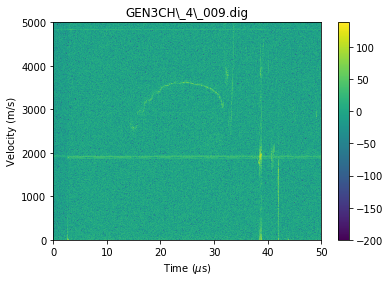

In [100]:
pcm = spec.plot(max_vel=5000, max_time = 50)
plt.show

In [102]:
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [28]:

def greedyCompare(time0intens, time1intens, start ):
    """ 
    Inputs: two arrays of intensities, at two times. indexes = velocity indexes
                start: the index in time0 of the current velocity selection
    Output: index of the greedy match
    """
    oldVelocity = time0intens[start]
    nextOptions = []
    for i in range(0,3): #makes -1,0,1
        nextOptions += [abs(oldVelocity-time1intens[start+i])]
    return start+nextOptions.index(min(nextOptions))


# intensities[:,0]
greedyCompare(intensities[:,0],intensities[:,1],7)
print(intensities[7,0])
print(intensities[9,1])
np.argmax(intensities[:,0])
intensities[150,0]

-13.19460909126565
-13.342340656917806


8.233639597589873

In [47]:
times,velocites,intensities = spec.slice((spec.time[0],spec.time[10]),(1000,2000))
intensities[np.argmax(intensities[:,0]),0]

22.689318753215222

AttributeError: 'Spectrogram' object has no attribute 'dt'